In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [3]:
def visualize_frame(frame_loc,indices,xmin=5,xmax=-5,ymin=-5,ymax=5):
    frames = np.load(frame_loc)
    for i in indices:
        frame = frames[i]
        plt.figure(figsize=(10, 10))
        plt.scatter(frame[:, 0], frame[:, 1])
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.show()
        plt.close()
    

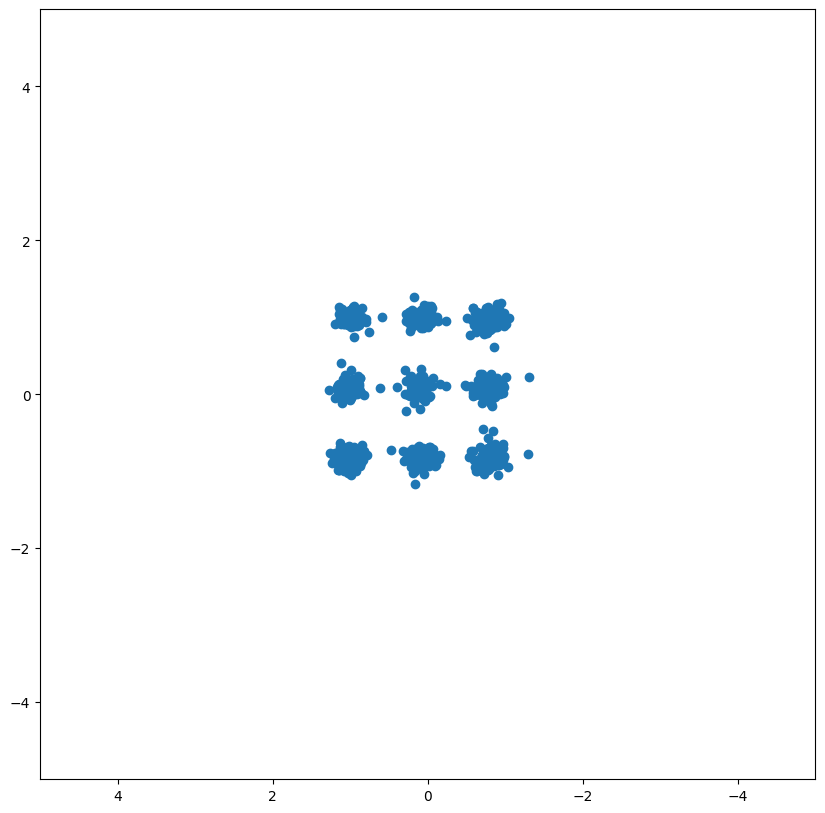

In [5]:
frame_locs = 'exps/base/frames.npy'
indices = [90]
visualize_frame(frame_locs,indices)

In [17]:
from datasets import GMDataset
from torch.utils.data import DataLoader

data = GMDataset(n=8000,modes=2)
train_loader = DataLoader(data, batch_size=64, shuffle=True)

[[ 0.  0.]
 [ 0. 50.]
 [50.  0.]
 [50. 50.]]


In [18]:
torch.manual_seed(12)
np.random.seed(12)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(12)
torch.backends.cudnn.benchmark = True

class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max, p=0.5):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        
        self.linear_model1 = nn.Sequential(nn.Linear(2, 32),nn.GELU())
        self.embedding_layer = nn.Embedding(n_steps, 32)
        self.linear_model2 = nn.Sequential(nn.Linear(32, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 2))       
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)    
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            x_tilde = x

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x_tilde)
        embedding = self.embedding_layer(idx)
        output = self.linear_model2(output + embedding)
        output = output / used_sigmas

        return (output, target, used_sigmas) if get_target else output

In [19]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = T
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_perturbation_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        sample = (torch.rand([sampling_number,2]).to(device = self.device) - 0.5)*2
        sampling_list = []
        
        final = None
        for sample in self._one_perturbation_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

In [47]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def scatter(sample, only_final, scatter_range = [0, 50], title=None, save_name=None):
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(10, 10))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=10)
        if title:
            plt.title(title)
        if save_name:
            plt.savefig(save_name)
        plt.show()
    
    else:
        step_size = sample.size(0)
        fig, axs = plt.subplots(1, step_size, figsize=(step_size * 4, 4), constrained_layout = True)
        for i in range(step_size):
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y = scatter[:,0], scatter[:,1]
            axs[i].scatter(scatter_x, scatter_y, s=10)
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
        
        if title:
            fig.suptitle(title, fontsize=24)
        if save_name:
            plt.savefig(save_name)
        plt.show()
     

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [124]:
import random
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2, shape = (2),modes=2, probability=0.2, total_len = 1000000,max=20):
        """self.device='cuda'
        self.modes = modes
        self.dist1_mean, self.dist1_var = dist1[0], dist1[1]
        self.dist2_mean, self.dist2_var = dist2[0], dist2[1]
        xs = np.linspace(2, 10, self.modes)
        ys = [i / self.modes for i in range(self.modes)]
        self.means = np.array([(x, y) for x in xs for y in xs])
        self.means = np.array([(3,3),(-3,-3)])
        self.covariances = np.eye(2)
        print(self.means)
        self.X = np.concatenate([np.random.multivariate_normal(mean, self.covariances, total_len//len(self.means)) for mean in self.means])
        self.data = torch.from_numpy(self.X.astype(np.float32)).to(self.device)
        self.shape = shape
        self.total_len = total_len"""
        self.dist1_mean, self.dist1_var = dist1[0], dist1[1]
        self.dist2_mean, self.dist2_var = dist2[0], dist2[1]
        self.dist3_mean = torch.tensor([self.dist1_mean,self.dist2_mean])
        self.shape = shape
        self.probability = probability
        self.total_len = total_len
        self.data = torch.zeros((total_len, 2))
        self.modes = modes
        xs = np.linspace(2, max, self.modes)
        self.means = np.array([(x, y) for x in xs for y in xs])
        uniform = list(range(len(self.means)))
        for i in range(total_len):
            mean_idx = random.choice(uniform)
            mean = self.means[mean_idx]
            self.data[i] = torch.tensor(mean) + torch.randn(self.shape) * self.dist1_var
        
    @property
    def get_probability(self):
        return torch.rand(1) < self.probability
        
    @property
    def _sampling_1(self):
        return self.dist1_mean + torch.randn(self.shape) * self.dist1_var

    @property
    def _sampling_2(self):
        return self.dist2_mean + torch.randn(self.shape) * self.dist2_var
    @property
    def _sampling_1_2(self):
        return self.dist3_mean + torch.randn(self.shape) * self.dist1_var
    @property
    def _sampling_2_2(self,mean):
        return mean + torch.randn(self.shape) * self.dist2_var

    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        data = self.data[idx]
        return data

In [133]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100
device = torch.device('cuda')
model = Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

scatter_range = [-2, 15]
total_iteration = 50000
display_iteration = 500
sampling_number = 10000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

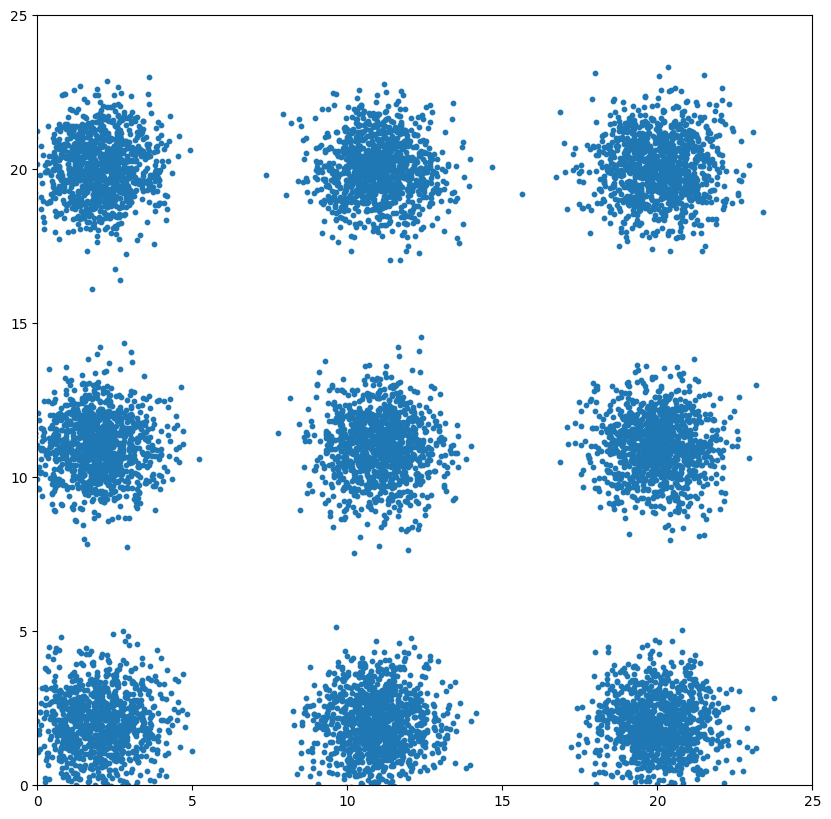

In [134]:
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.5
batch_size = 128
dataset = DataSet(dist1, dist2, probability=probability, total_len=10000,modes=3,max=20)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

xx = [dataset.__getitem__(i) for i in range(len(dataset))]
xx = torch.stack(xx, dim=0)
scatter_range = [0, 25]
scatter(xx, True, save_name='dataset.jpg',scatter_range=scatter_range)

Iteration [  499/50000]	Loss 0.8907 (0.9265)

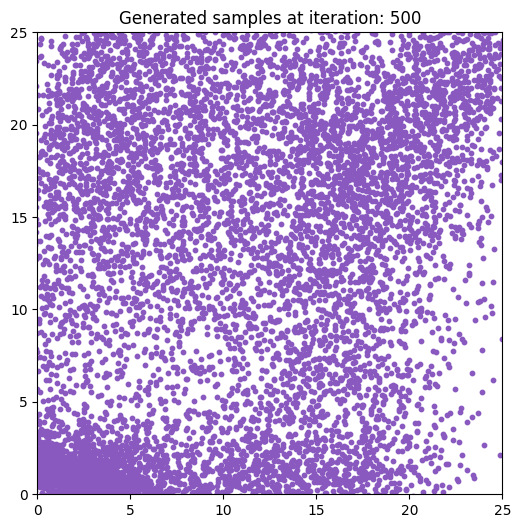

Iteration [  999/50000]	Loss 0.9010 (0.9092)

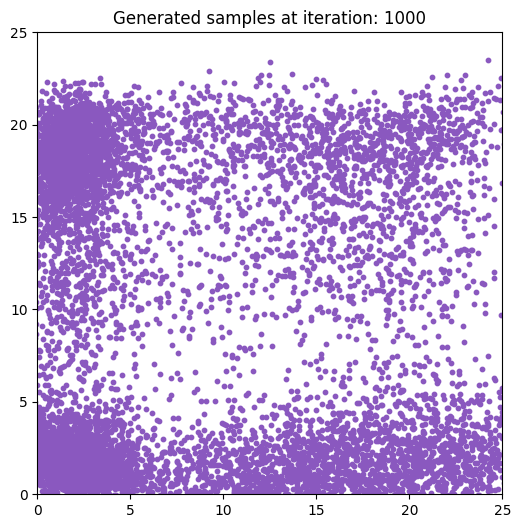

Iteration [ 1499/50000]	Loss 0.7882 (0.8952)

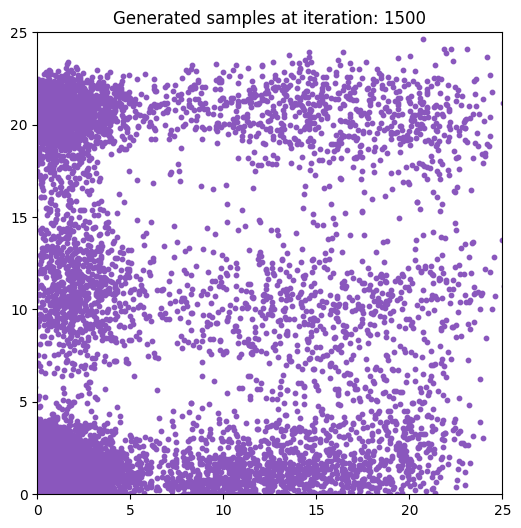

Iteration [ 1999/50000]	Loss 0.8283 (0.8864)

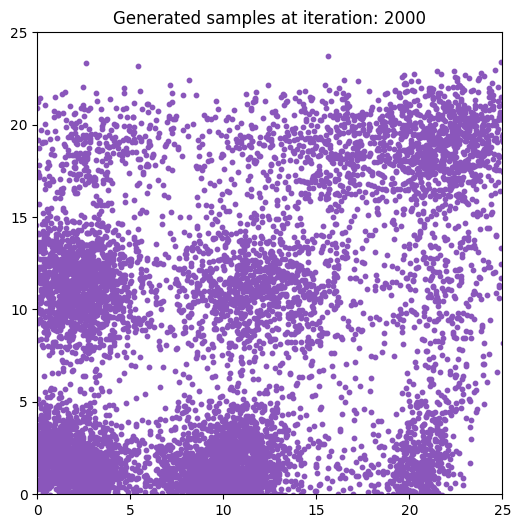

Iteration [ 2499/50000]	Loss 0.8376 (0.8784)

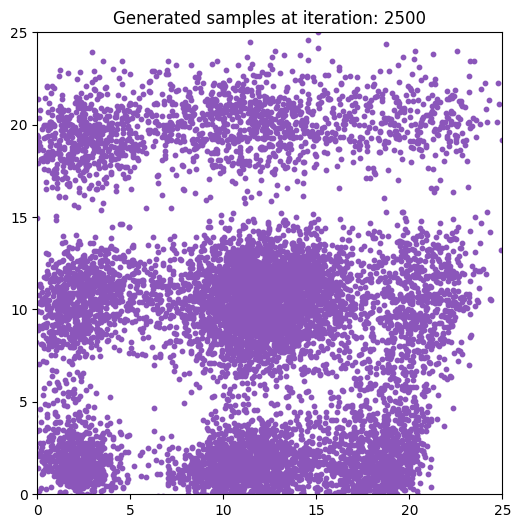

Iteration [ 2999/50000]	Loss 0.8062 (0.8721)

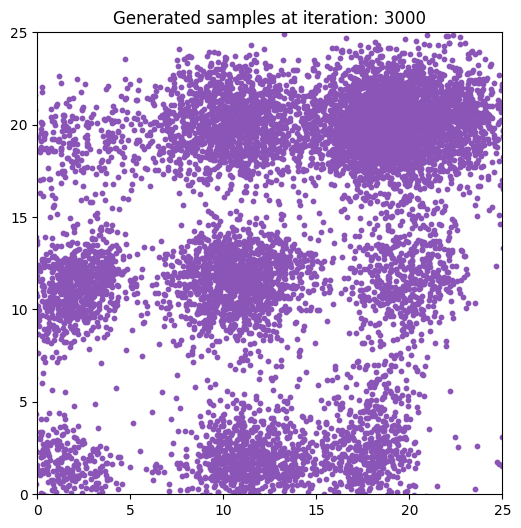

Iteration [ 3499/50000]	Loss 0.8100 (0.8665)

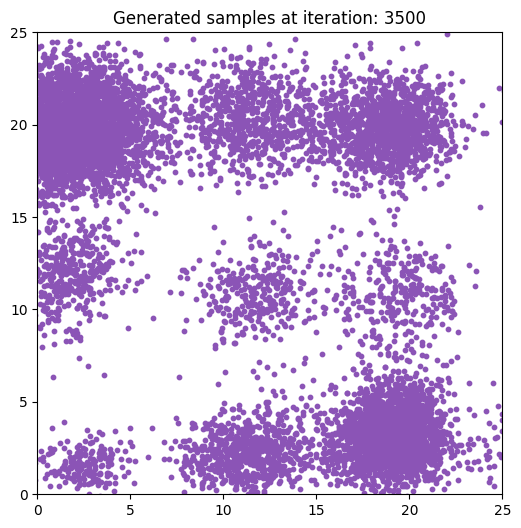

Iteration [ 3999/50000]	Loss 0.8071 (0.8621)

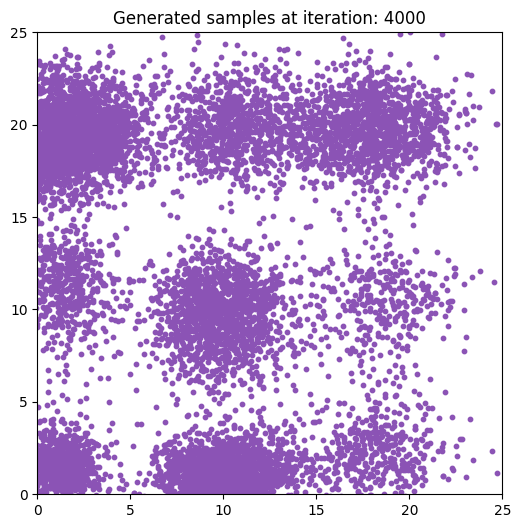

Iteration [ 4499/50000]	Loss 0.8780 (0.8585)

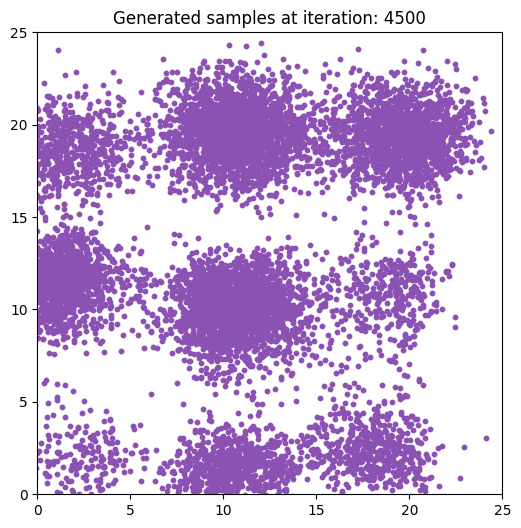

Iteration [ 4999/50000]	Loss 1.0721 (0.8552)

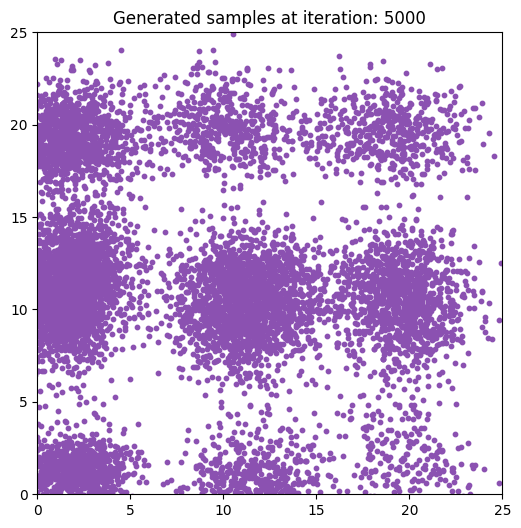

Iteration [ 5499/50000]	Loss 0.8045 (0.8532)

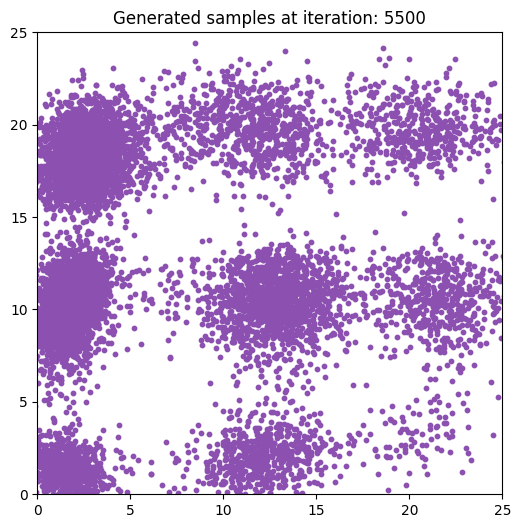

Iteration [ 5999/50000]	Loss 0.8646 (0.8512)

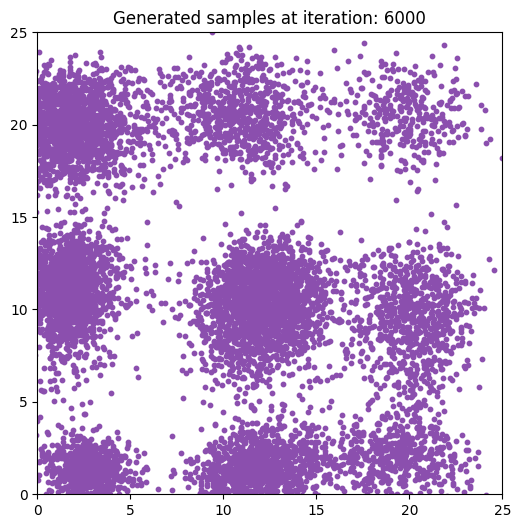

Iteration [ 6499/50000]	Loss 0.8692 (0.8498)

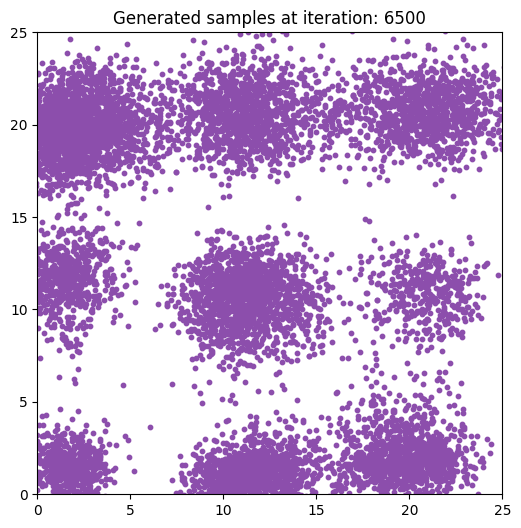

Iteration [ 6999/50000]	Loss 1.0535 (0.8485)

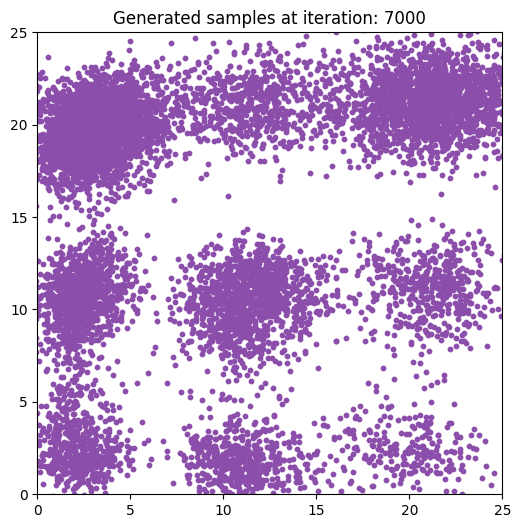

Iteration [ 7499/50000]	Loss 0.5716 (0.8475)

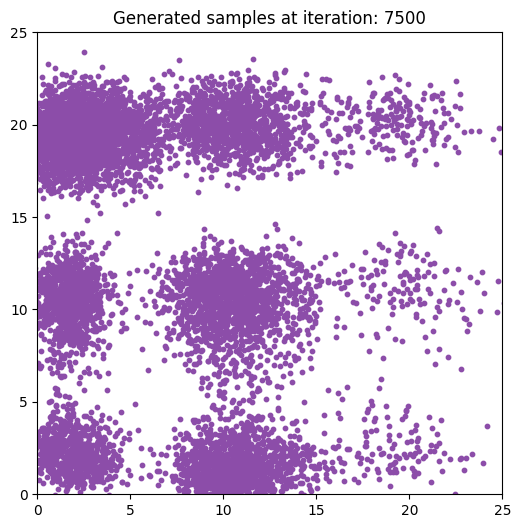

Iteration [ 7999/50000]	Loss 0.8230 (0.8464)

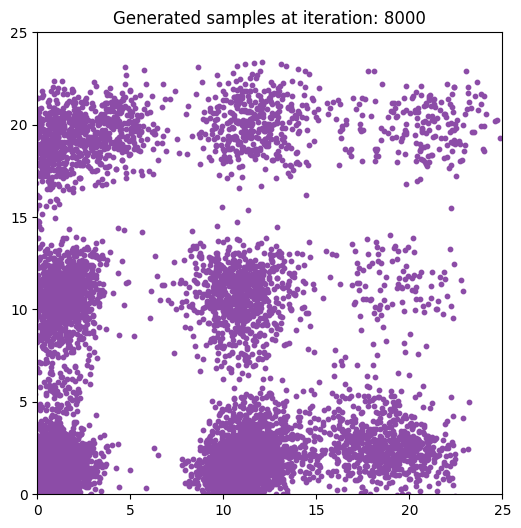

Iteration [ 8499/50000]	Loss 0.8481 (0.8453)

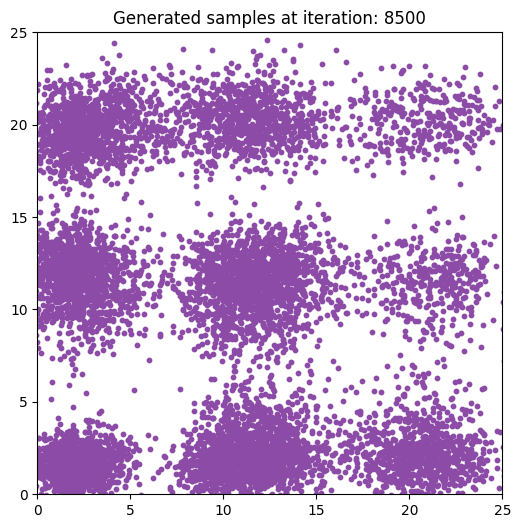

Iteration [ 8999/50000]	Loss 0.8886 (0.8442)

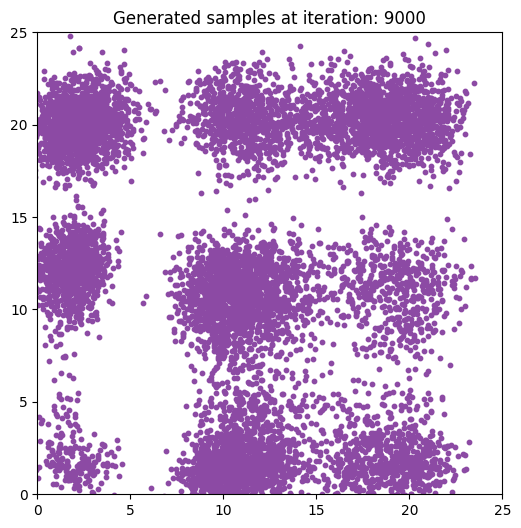

Iteration [ 9499/50000]	Loss 0.8311 (0.8433)

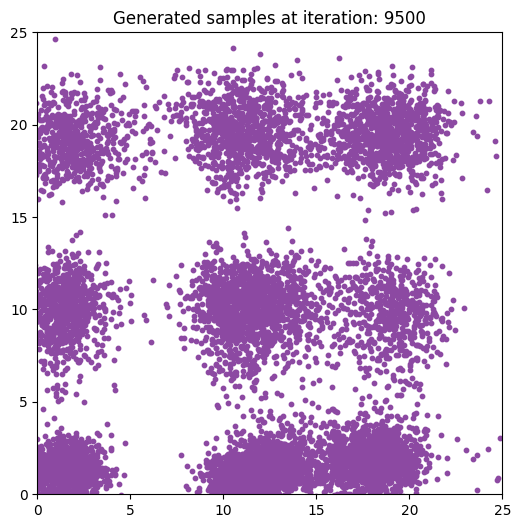

Iteration [ 9999/50000]	Loss 0.8164 (0.8424)

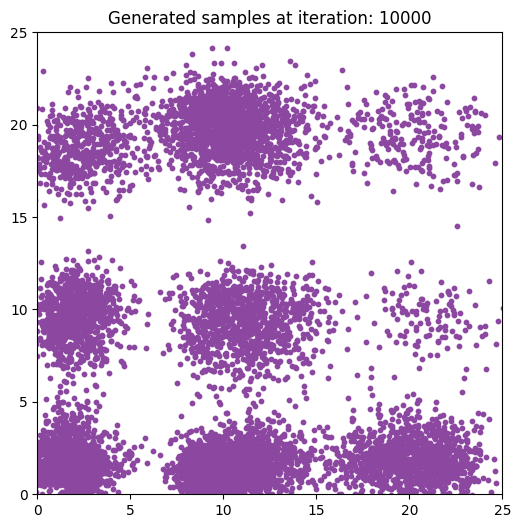

Iteration [10499/50000]	Loss 0.8761 (0.8415)

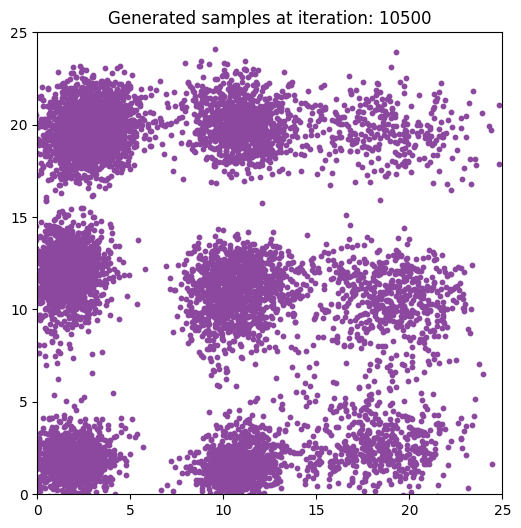

Iteration [10999/50000]	Loss 0.8224 (0.8406)

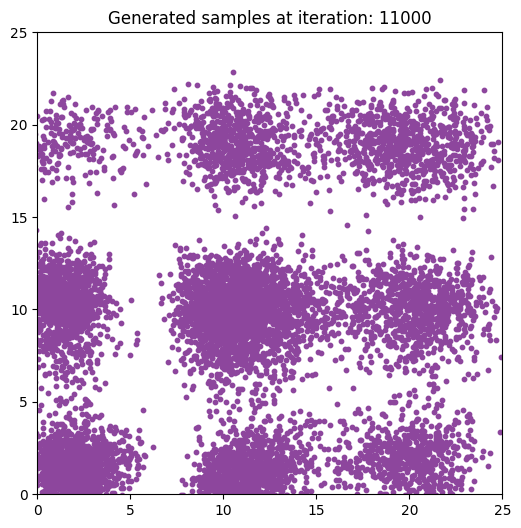

Iteration [11499/50000]	Loss 0.8307 (0.8398)

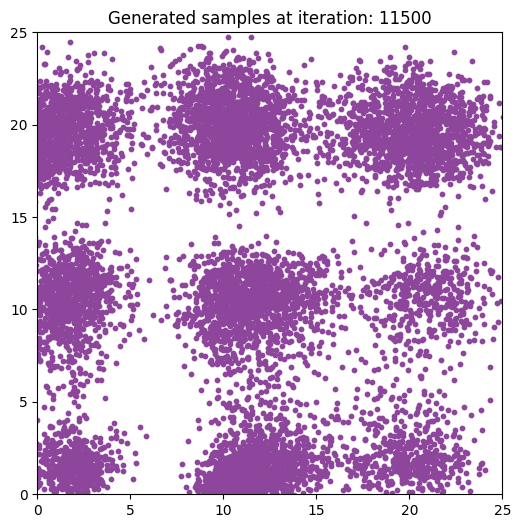

Iteration [11999/50000]	Loss 0.8653 (0.8389)

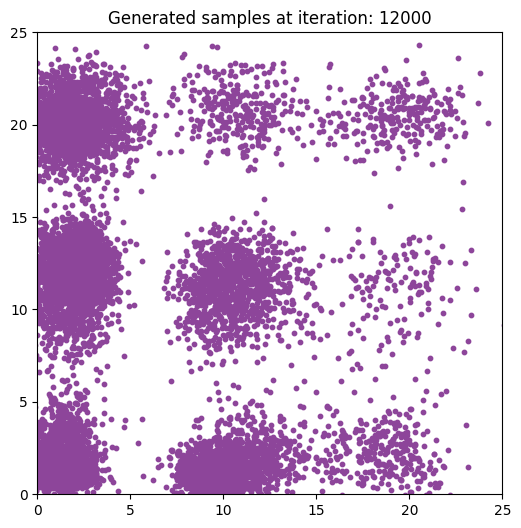

Iteration [12499/50000]	Loss 0.7226 (0.8382)

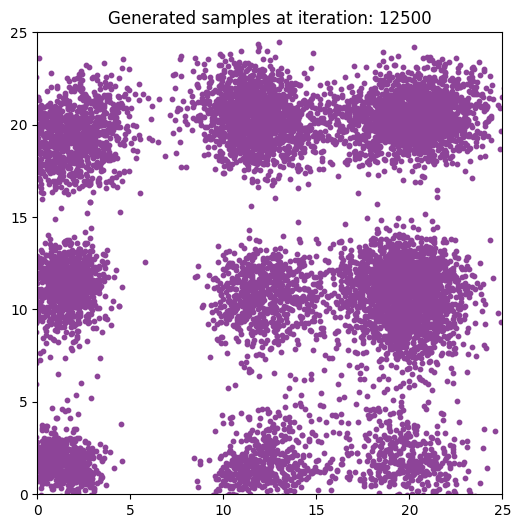

Iteration [12999/50000]	Loss 0.8499 (0.8374)

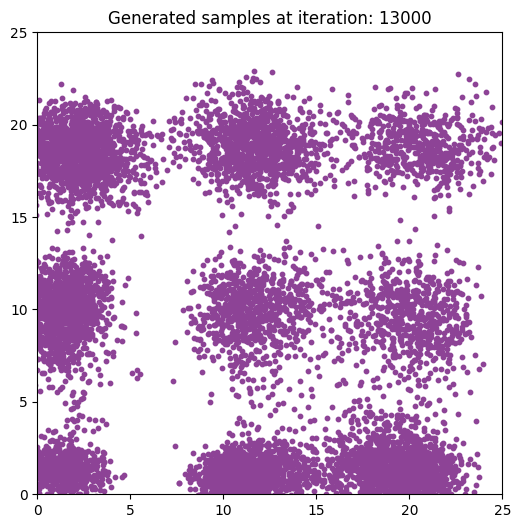

Iteration [13499/50000]	Loss 0.7012 (0.8369)

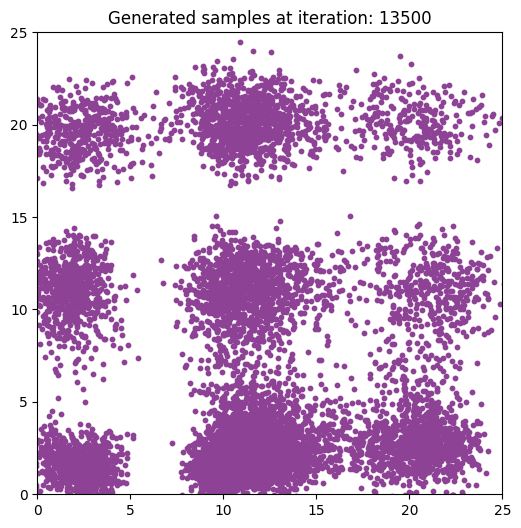

Iteration [13999/50000]	Loss 0.7692 (0.8363)

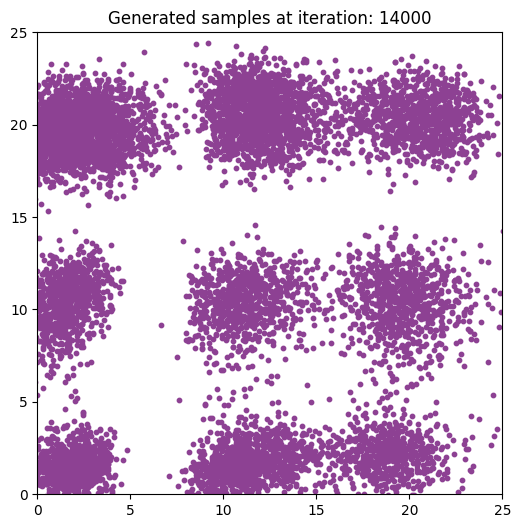

Iteration [14499/50000]	Loss 0.8856 (0.8358)

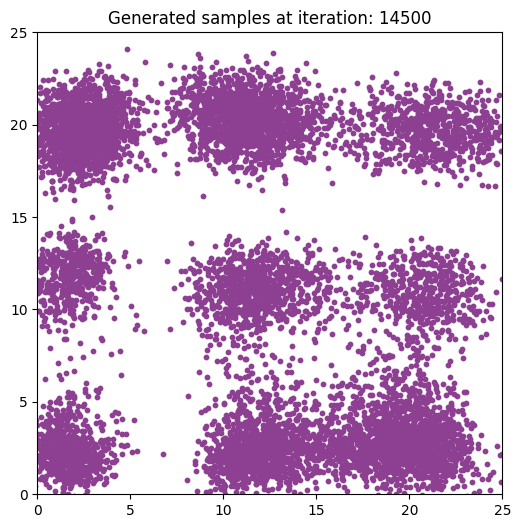

Iteration [14999/50000]	Loss 0.7743 (0.8351)

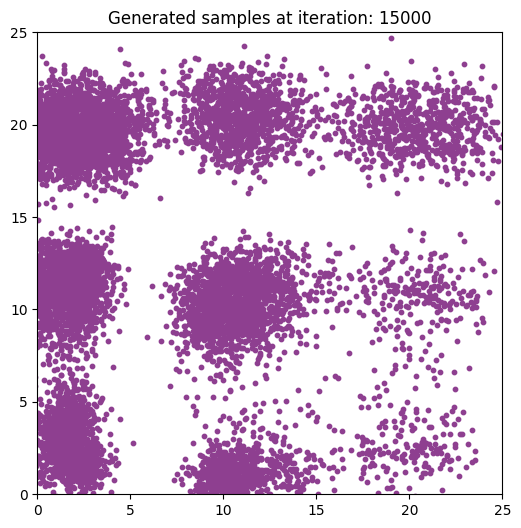

Iteration [15499/50000]	Loss 0.9213 (0.8346)

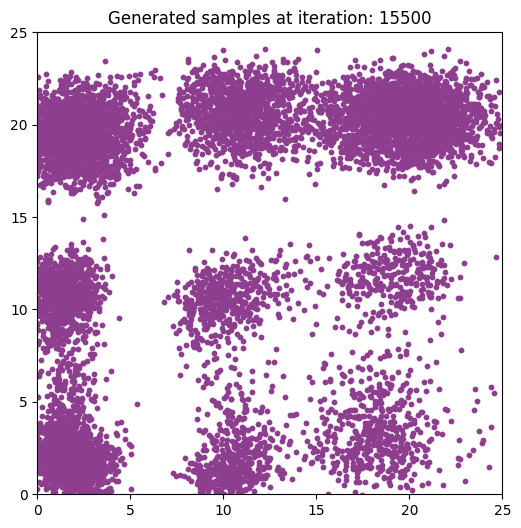

Iteration [15999/50000]	Loss 0.7449 (0.8342)

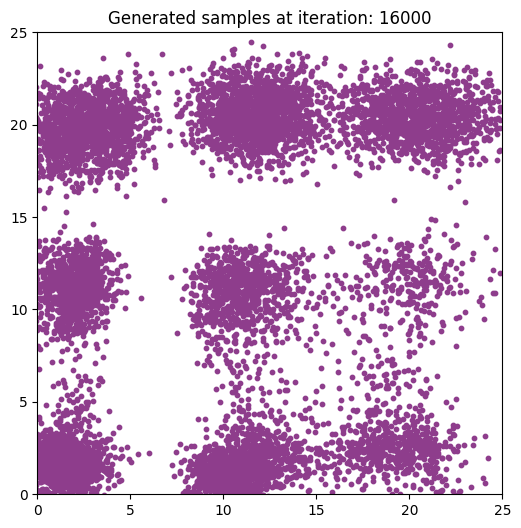

Iteration [16499/50000]	Loss 0.7183 (0.8336)

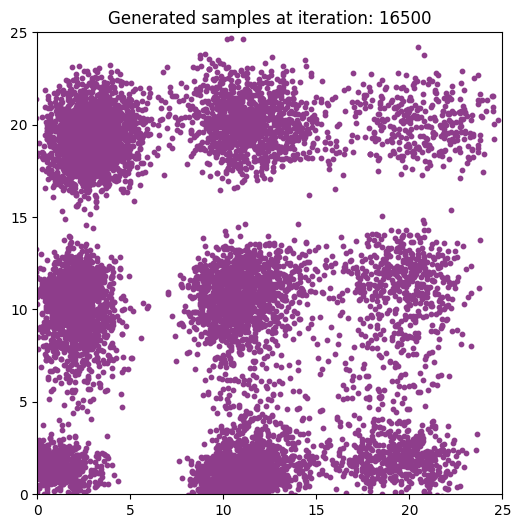

Iteration [16999/50000]	Loss 0.7833 (0.8331)

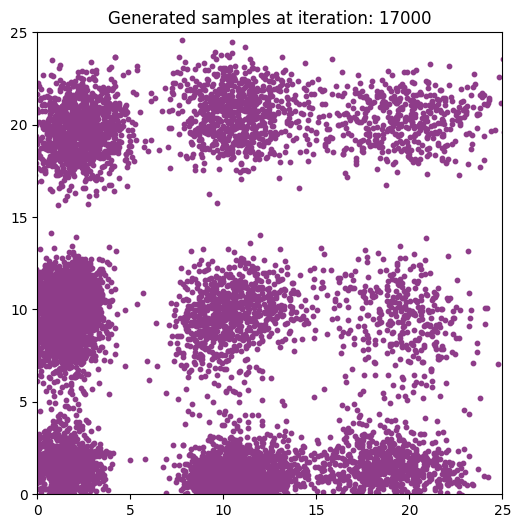

Iteration [17499/50000]	Loss 0.9141 (0.8326)

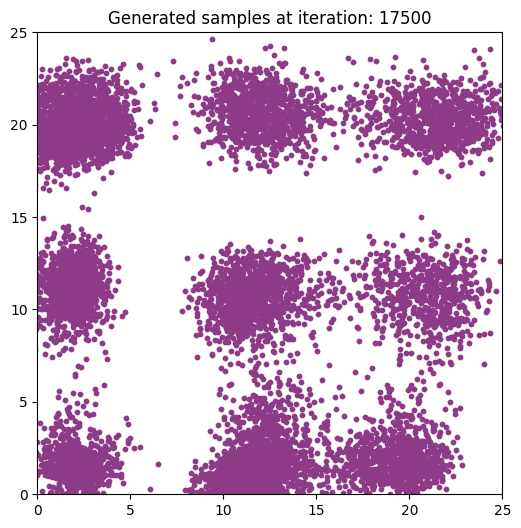

Iteration [17999/50000]	Loss 0.6729 (0.8321)

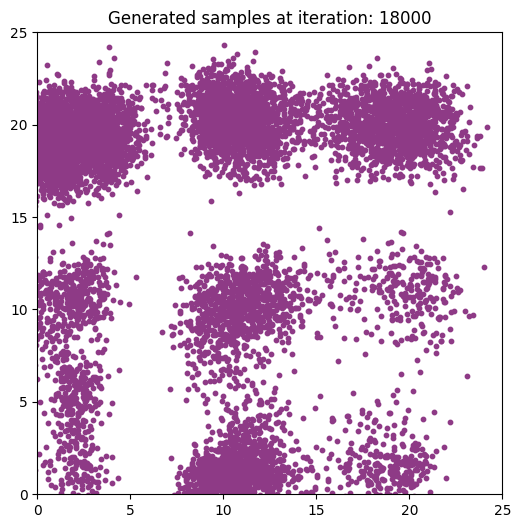

Iteration [18499/50000]	Loss 0.8382 (0.8318)

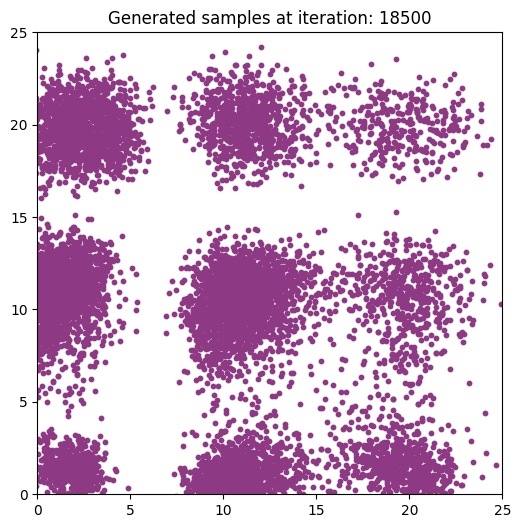

Iteration [18999/50000]	Loss 0.6551 (0.8313)

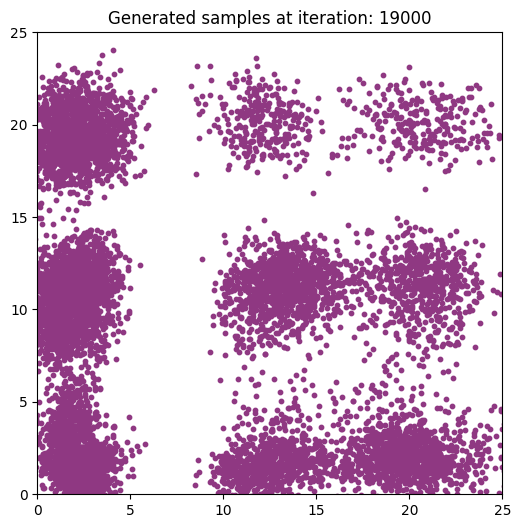

Iteration [19499/50000]	Loss 0.8333 (0.8309)

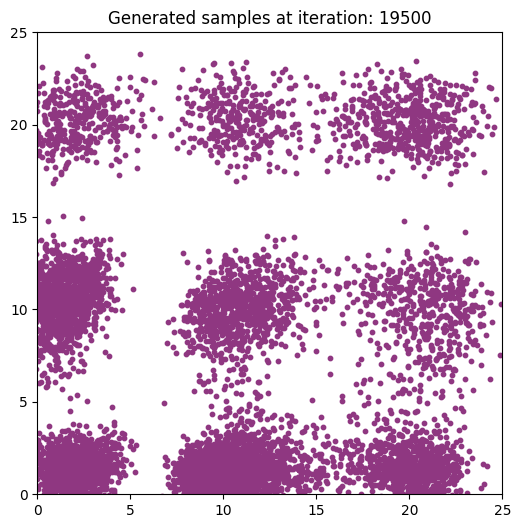

Iteration [19999/50000]	Loss 0.7628 (0.8306)

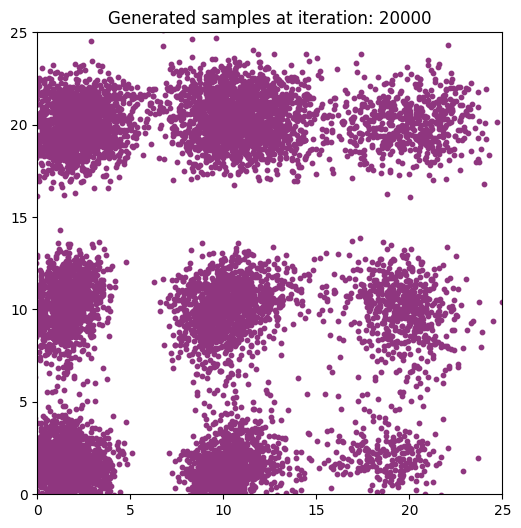

Iteration [20499/50000]	Loss 0.7395 (0.8302)

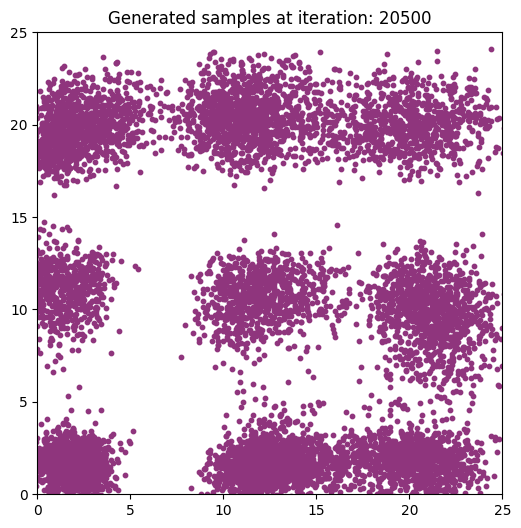

Iteration [20999/50000]	Loss 0.7761 (0.8299)

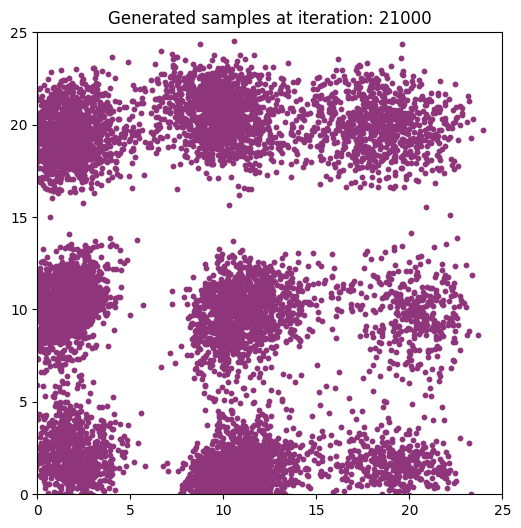

Iteration [21499/50000]	Loss 0.9323 (0.8297)

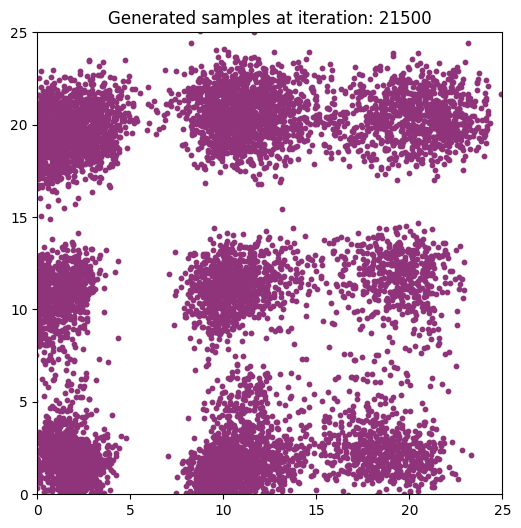

Iteration [21999/50000]	Loss 0.7615 (0.8294)

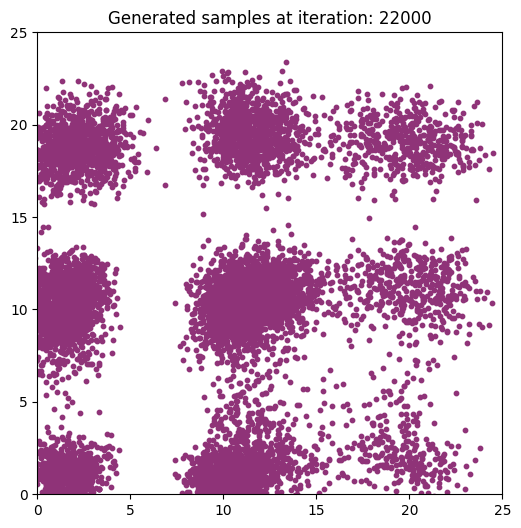

Iteration [22499/50000]	Loss 1.0824 (0.8290)

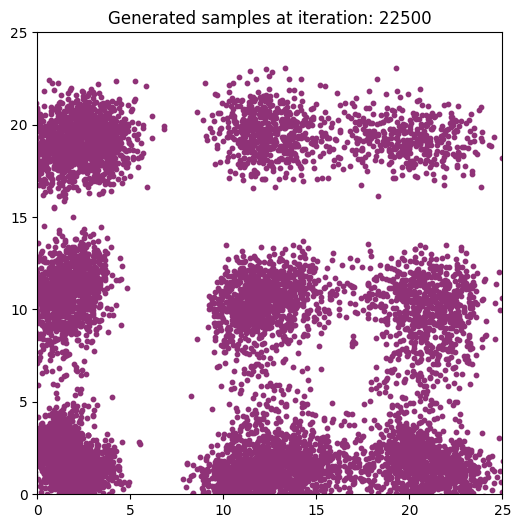

Iteration [22999/50000]	Loss 0.7345 (0.8288)

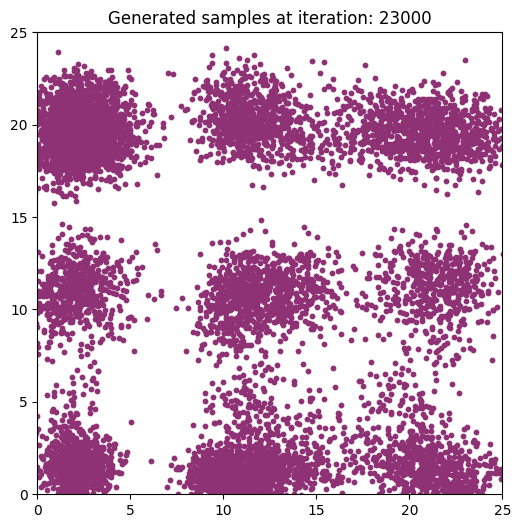

Iteration [23499/50000]	Loss 0.8256 (0.8284)

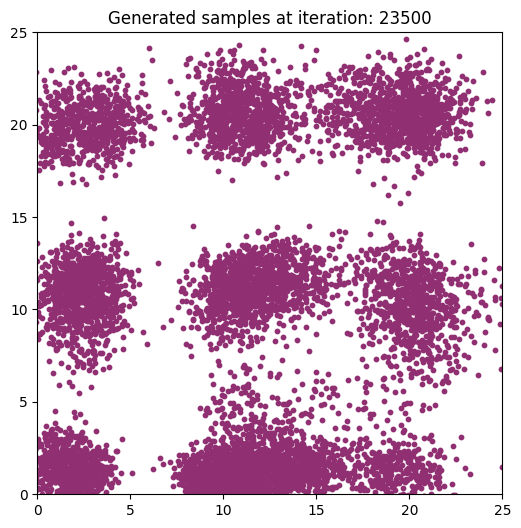

Iteration [23999/50000]	Loss 0.8969 (0.8281)

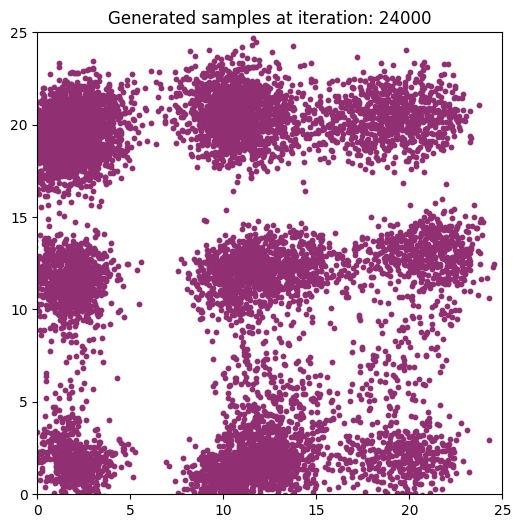

Iteration [24499/50000]	Loss 0.7320 (0.8278)

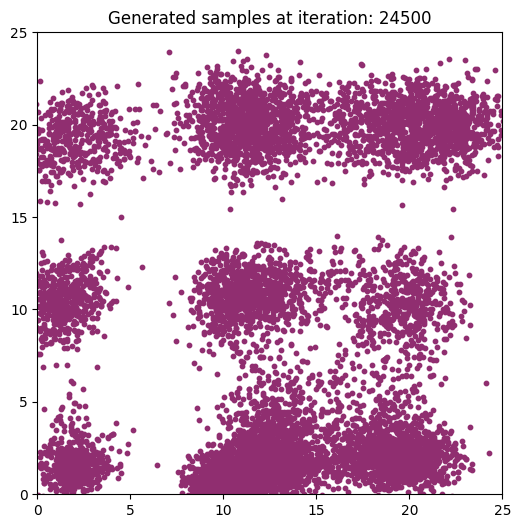

Iteration [24999/50000]	Loss 0.8194 (0.8274)

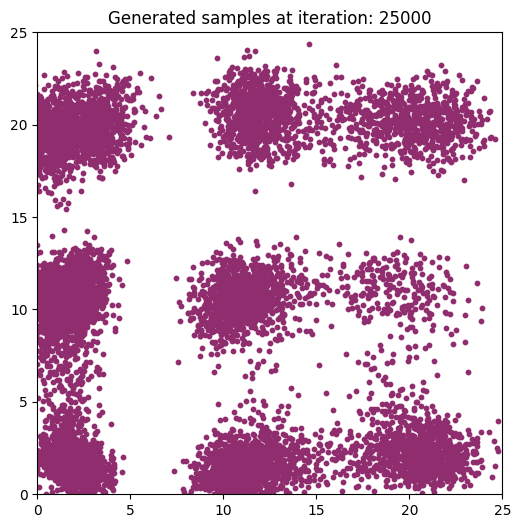

Iteration [25499/50000]	Loss 0.7733 (0.8272)

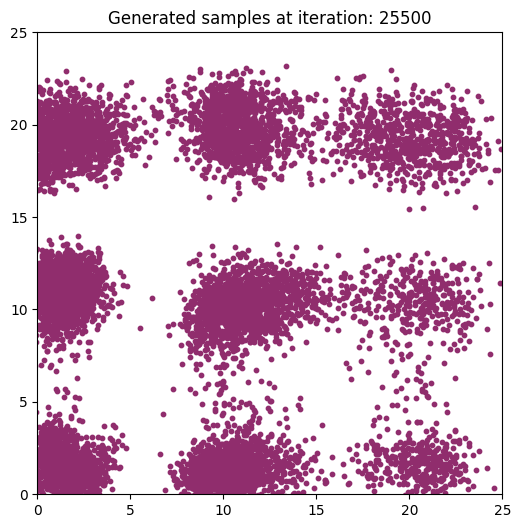

Iteration [25999/50000]	Loss 0.7751 (0.8269)

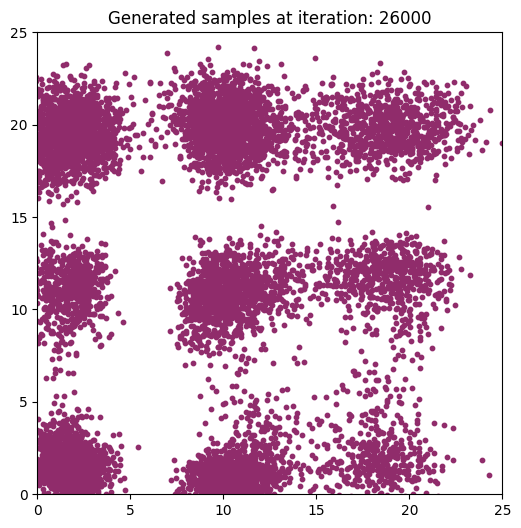

Iteration [26499/50000]	Loss 0.8036 (0.8265)

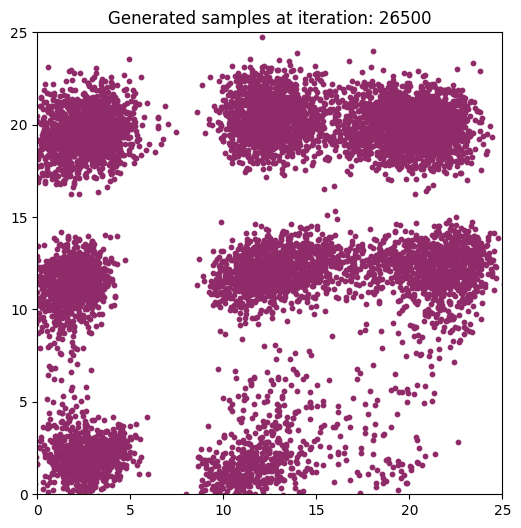

Iteration [26999/50000]	Loss 0.6856 (0.8264)

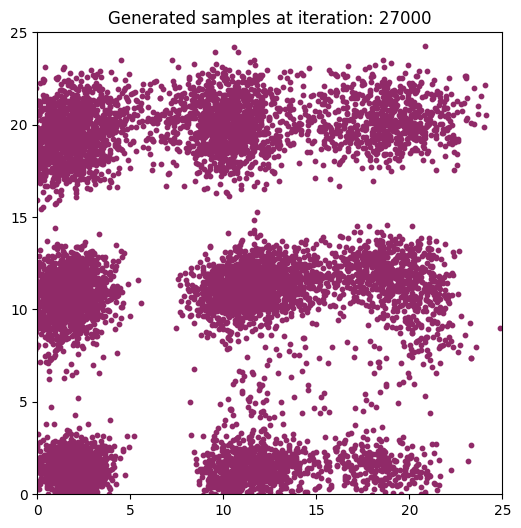

Iteration [27499/50000]	Loss 0.9431 (0.8261)

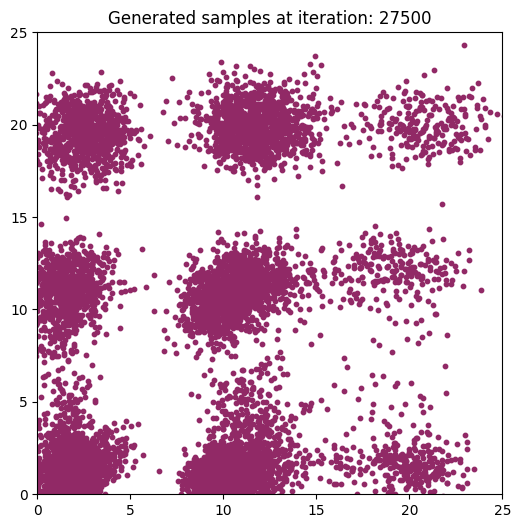

Iteration [27999/50000]	Loss 0.6728 (0.8257)

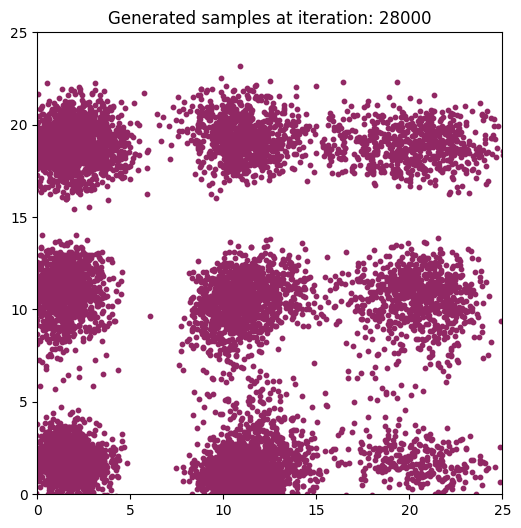

Iteration [28499/50000]	Loss 0.7128 (0.8254)

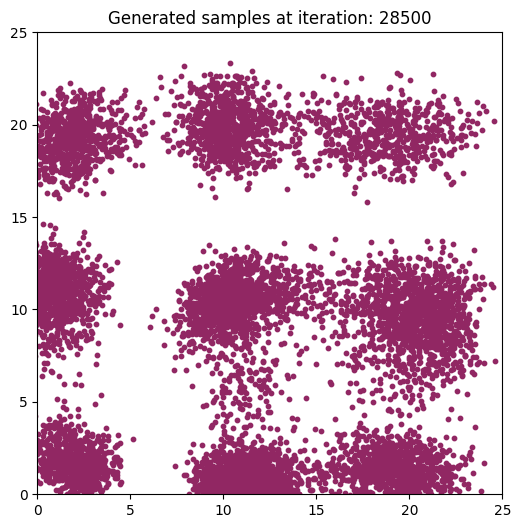

Iteration [28999/50000]	Loss 0.7856 (0.8252)

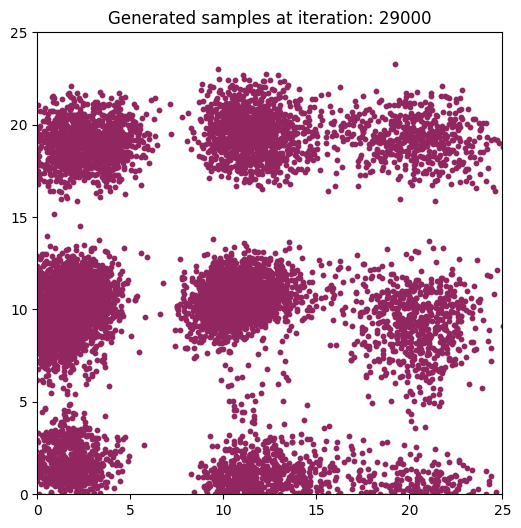

Iteration [29499/50000]	Loss 0.6842 (0.8250)

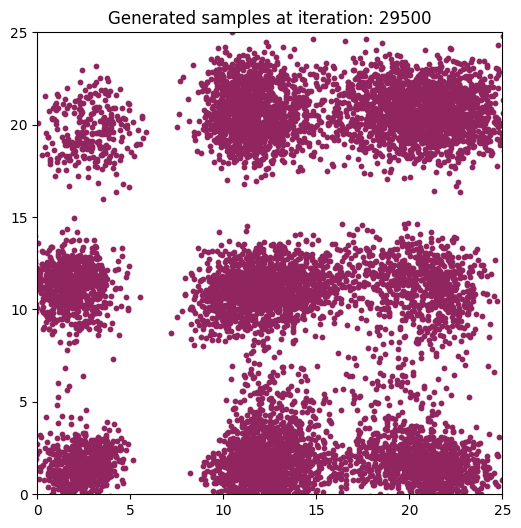

Iteration [29999/50000]	Loss 0.7541 (0.8247)

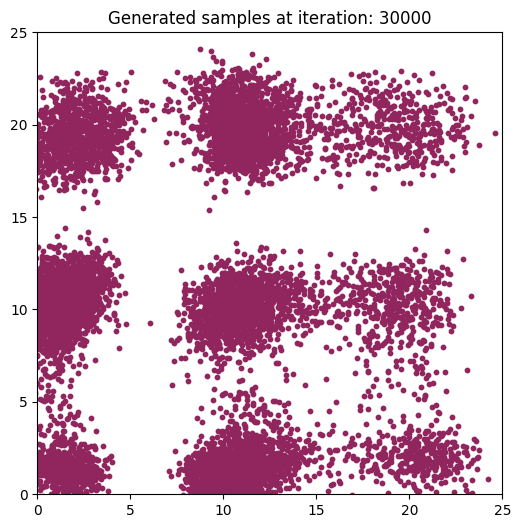

Iteration [30499/50000]	Loss 0.8451 (0.8245)

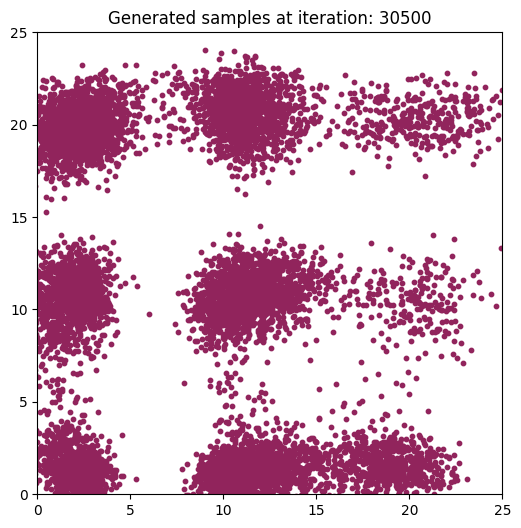

Iteration [30999/50000]	Loss 0.7823 (0.8244)

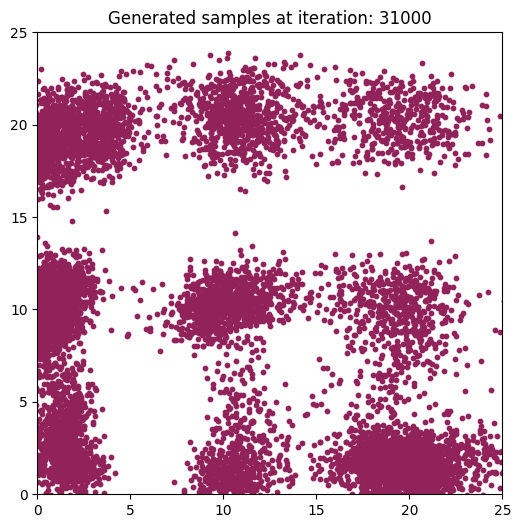

Iteration [31499/50000]	Loss 0.8441 (0.8242)

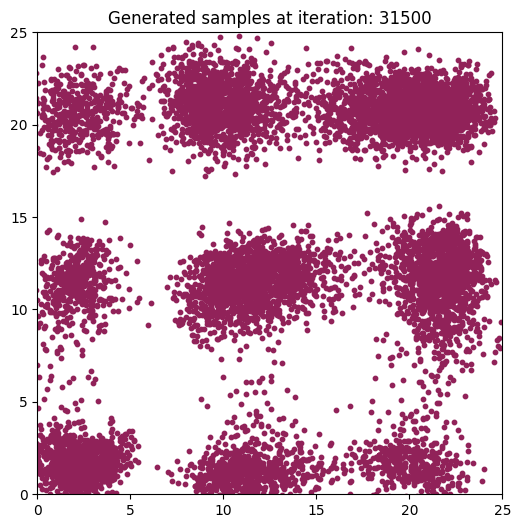

Iteration [31999/50000]	Loss 0.7849 (0.8240)

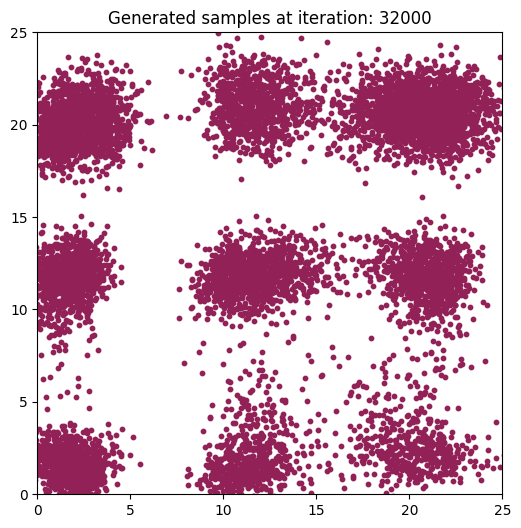

Iteration [32499/50000]	Loss 0.8297 (0.8238)

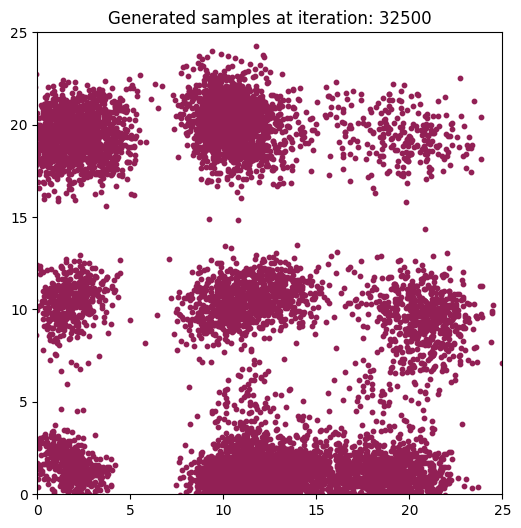

Iteration [32999/50000]	Loss 0.8250 (0.8235)

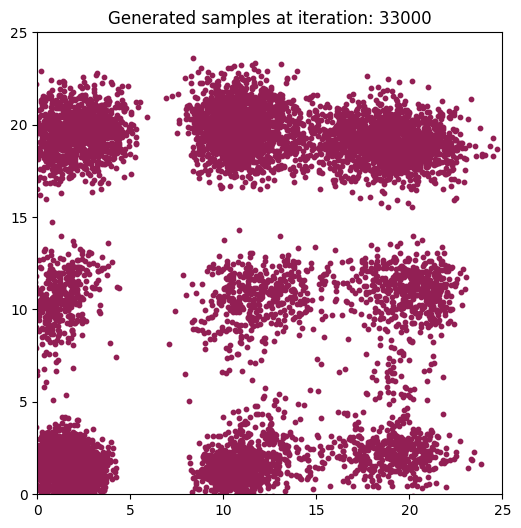

Iteration [33499/50000]	Loss 0.7682 (0.8233)

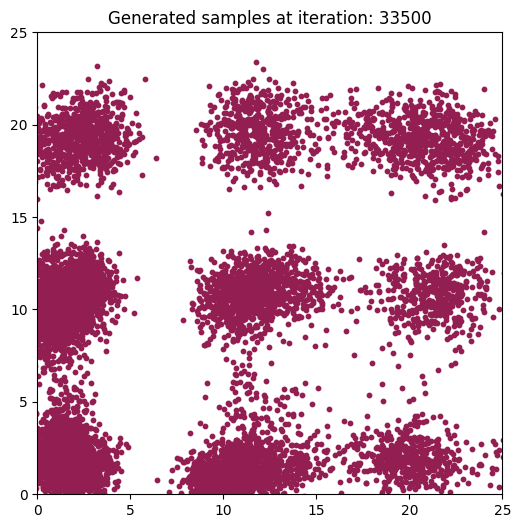

Iteration [33999/50000]	Loss 0.7561 (0.8231)

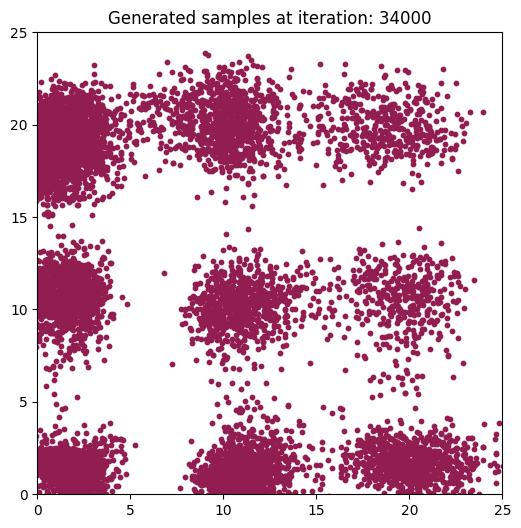

Iteration [34499/50000]	Loss 0.7599 (0.8229)

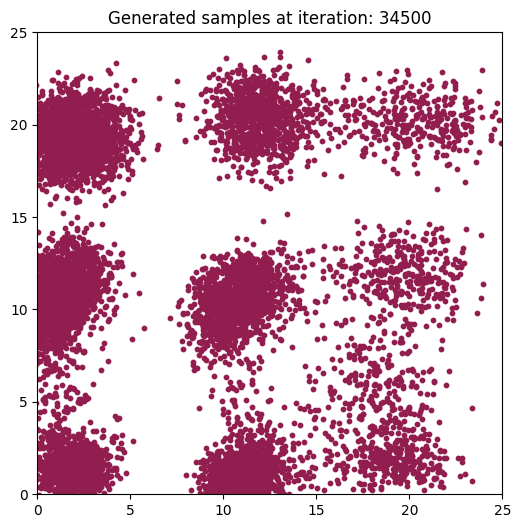

Iteration [34999/50000]	Loss 0.7945 (0.8228)

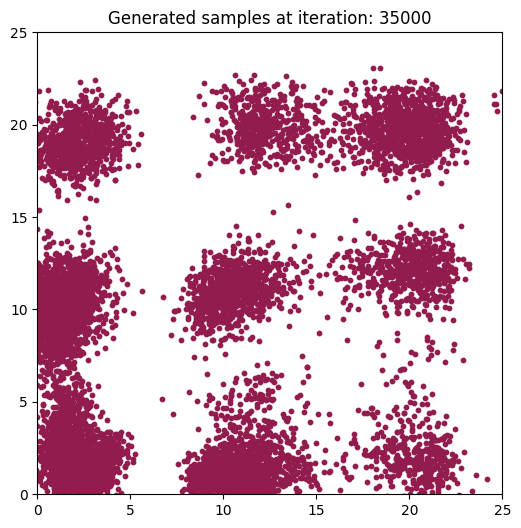

Iteration [35499/50000]	Loss 0.7330 (0.8227)

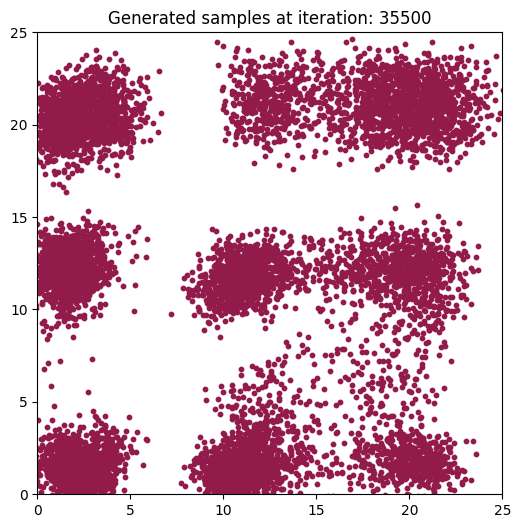

Iteration [35999/50000]	Loss 0.9399 (0.8224)

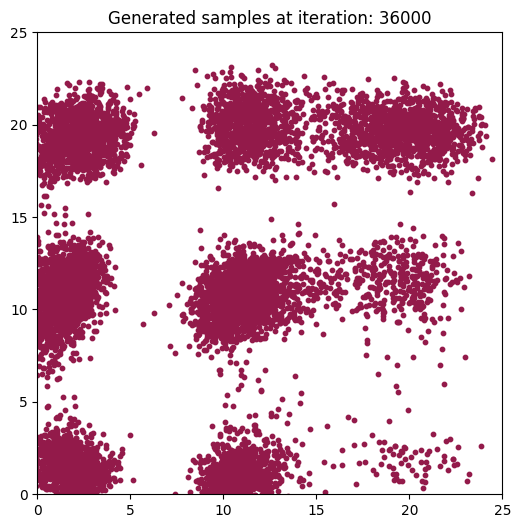

Iteration [36499/50000]	Loss 0.9055 (0.8223)

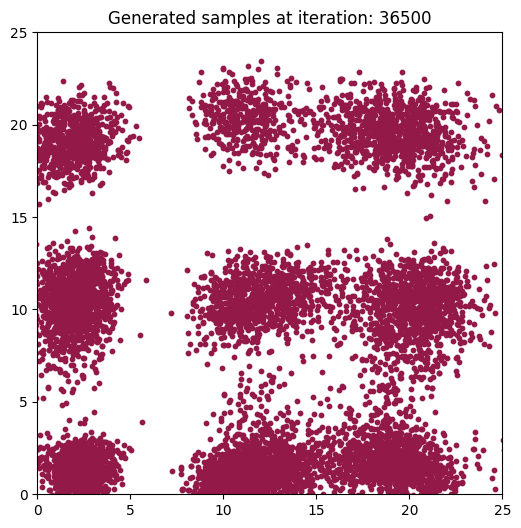

Iteration [36999/50000]	Loss 0.7801 (0.8222)

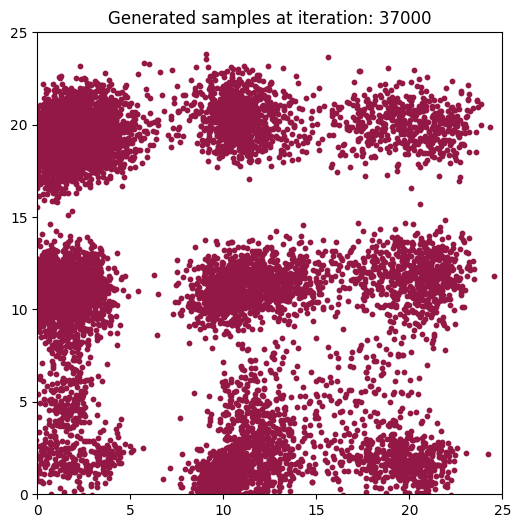

Iteration [37499/50000]	Loss 0.8471 (0.8219)

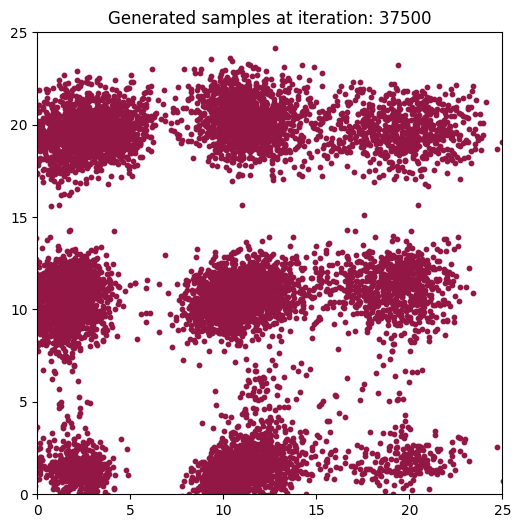

Iteration [37999/50000]	Loss 0.7864 (0.8218)

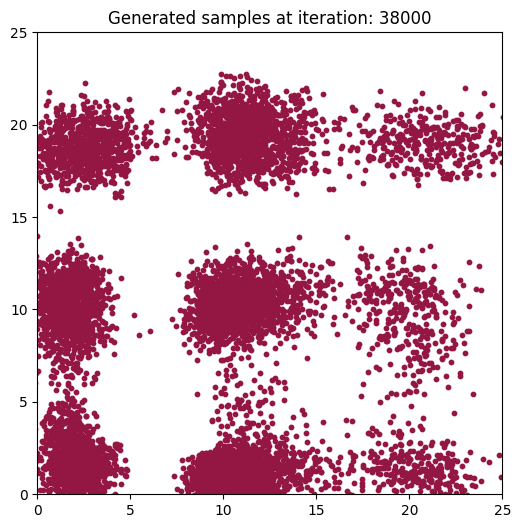

Iteration [38499/50000]	Loss 0.8318 (0.8216)

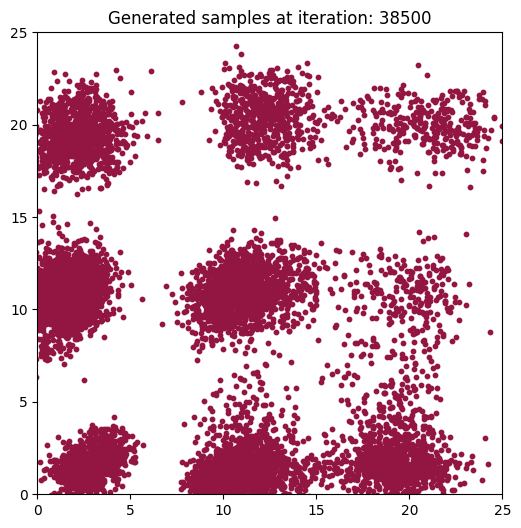

Iteration [38999/50000]	Loss 0.7656 (0.8215)

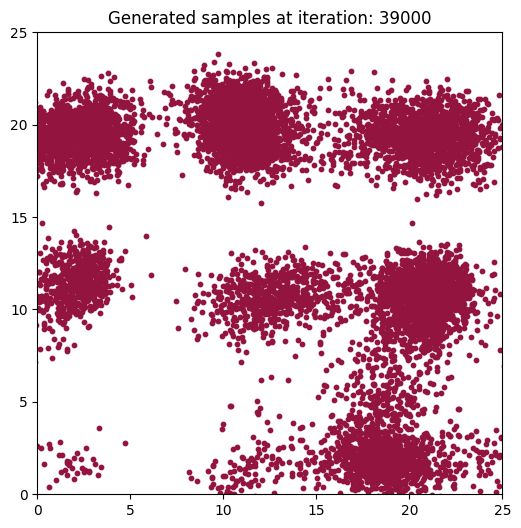

Iteration [39499/50000]	Loss 0.7726 (0.8213)

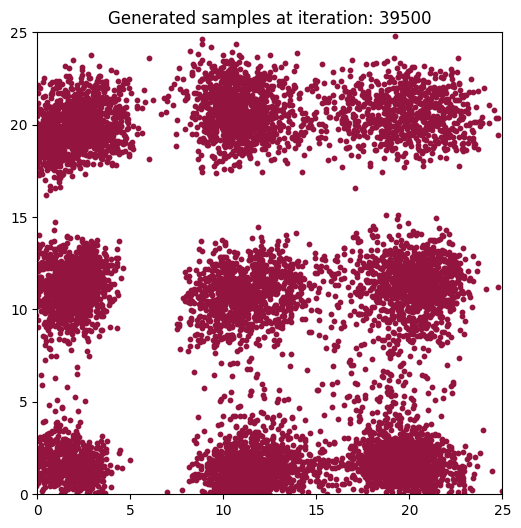

Iteration [39999/50000]	Loss 1.0258 (0.8212)

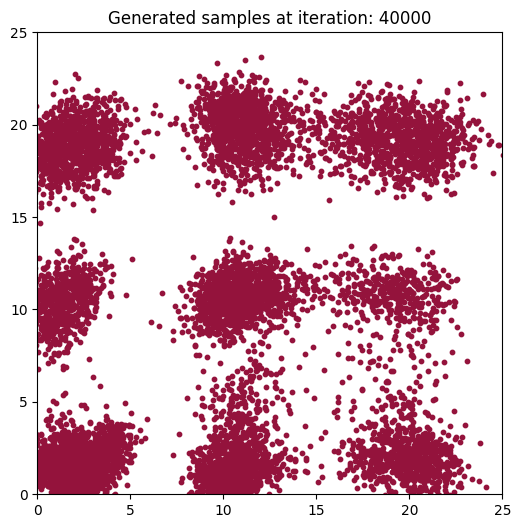

Iteration [40499/50000]	Loss 0.7354 (0.8211)

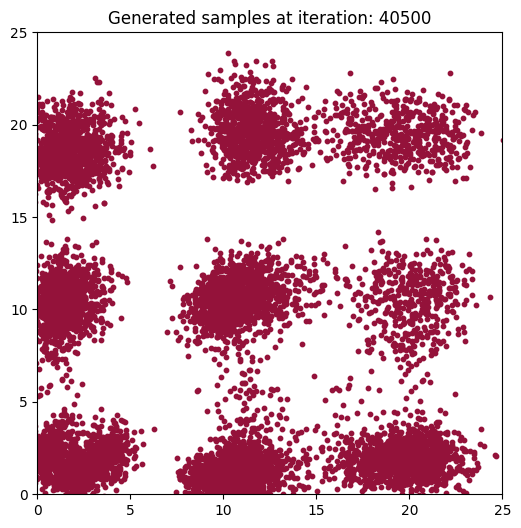

Iteration [40999/50000]	Loss 0.7255 (0.8209)

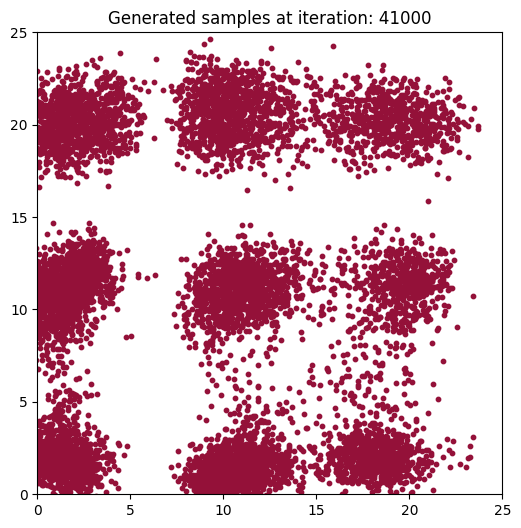

Iteration [41499/50000]	Loss 0.8445 (0.8208)

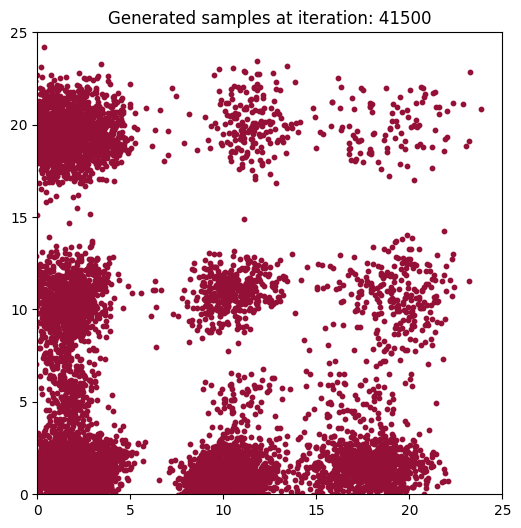

Iteration [41999/50000]	Loss 0.8855 (0.8206)

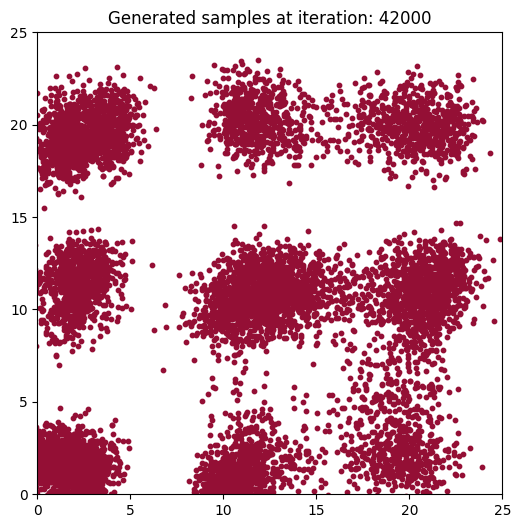

Iteration [42499/50000]	Loss 0.7299 (0.8204)

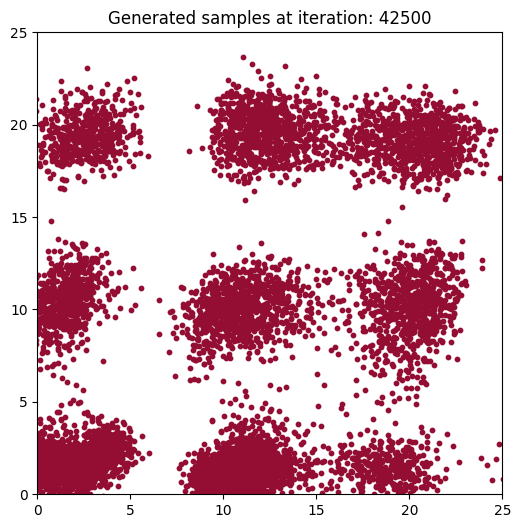

Iteration [42999/50000]	Loss 0.9892 (0.8203)

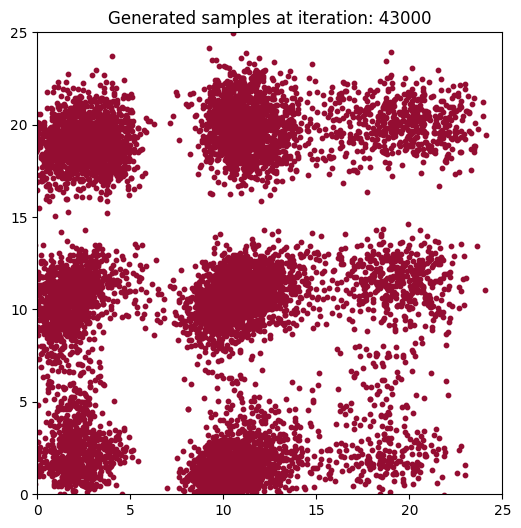

Iteration [43499/50000]	Loss 0.7845 (0.8202)

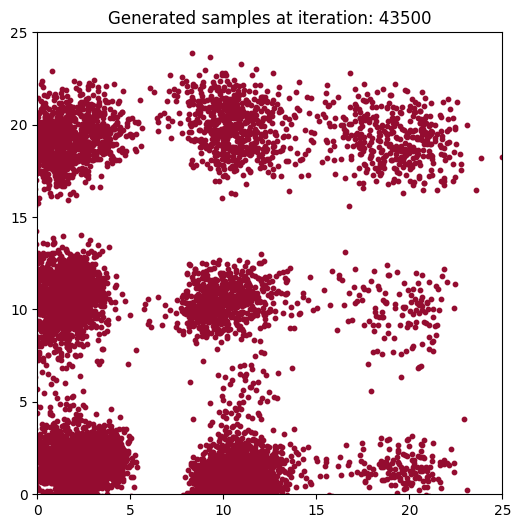

Iteration [43999/50000]	Loss 0.7831 (0.8200)

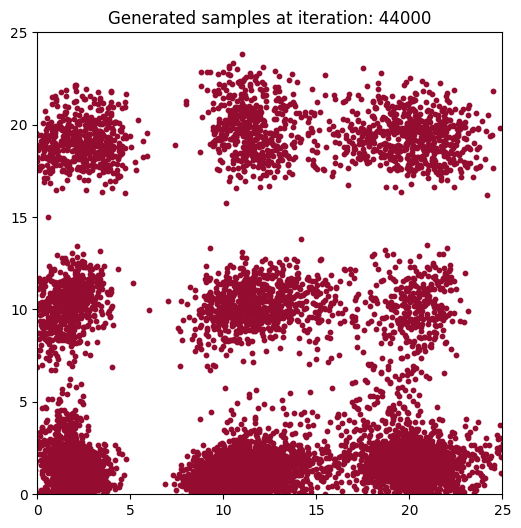

Iteration [44499/50000]	Loss 0.9087 (0.8199)

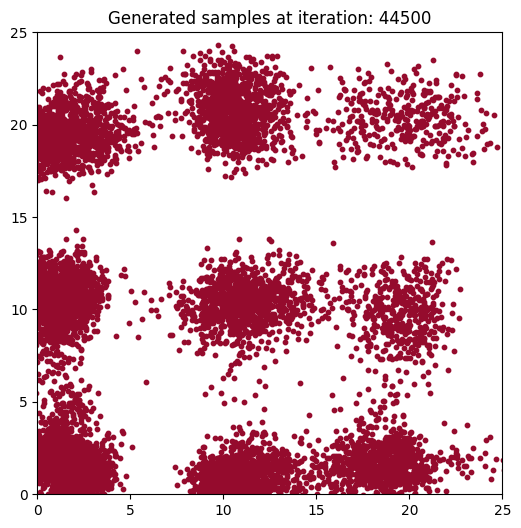

Iteration [44999/50000]	Loss 0.8779 (0.8197)

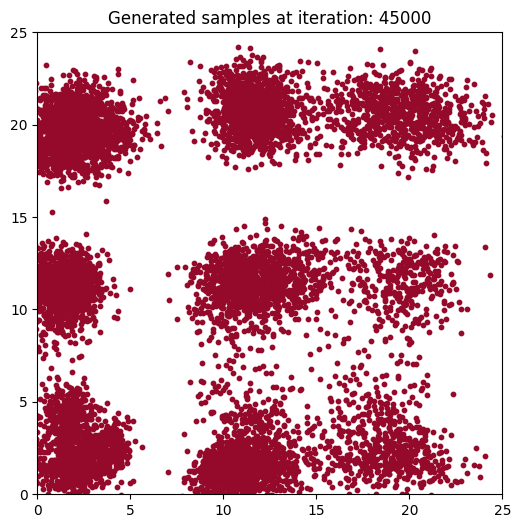

Iteration [45499/50000]	Loss 0.7738 (0.8196)

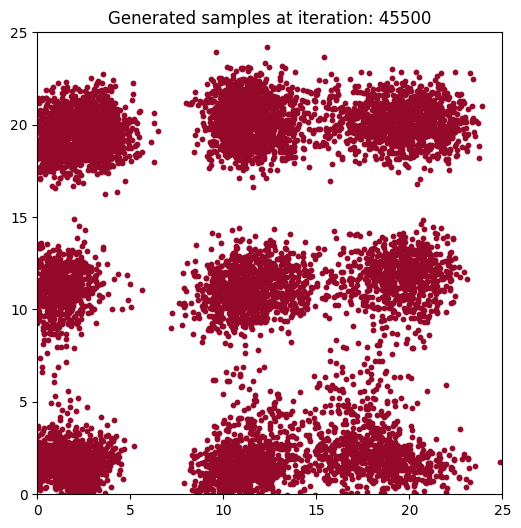

Iteration [45999/50000]	Loss 0.9412 (0.8194)

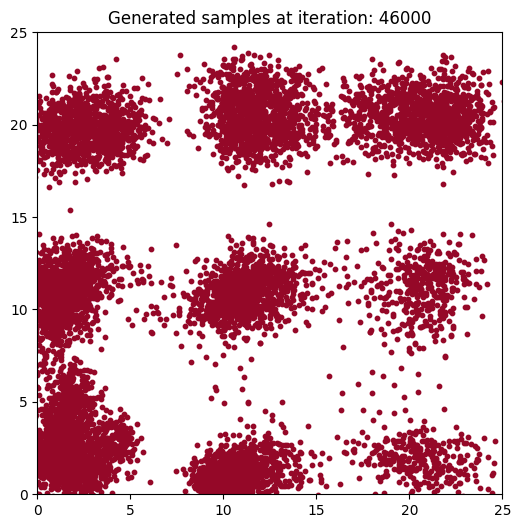

Iteration [46499/50000]	Loss 0.7838 (0.8193)

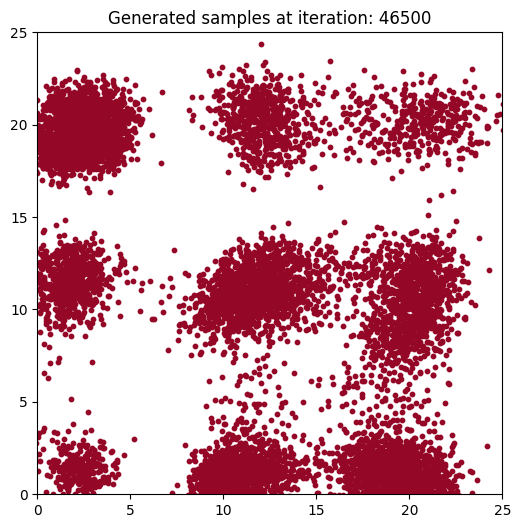

Iteration [46999/50000]	Loss 0.7848 (0.8192)

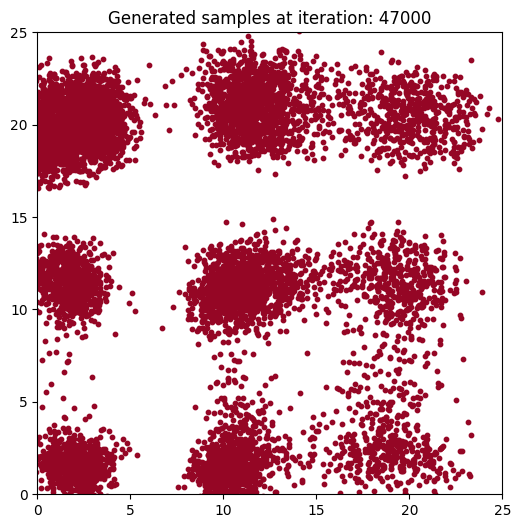

Iteration [47499/50000]	Loss 0.8415 (0.8191)

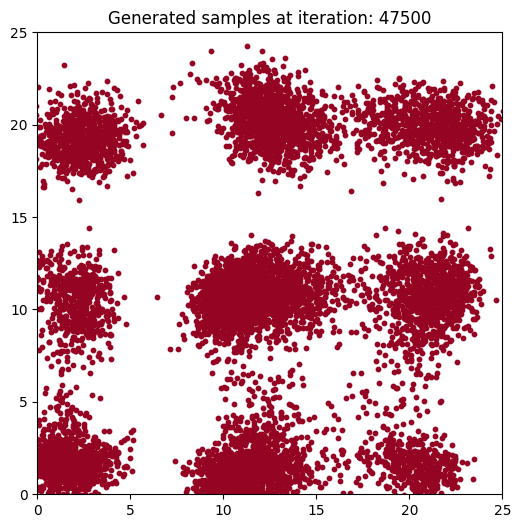

Iteration [47999/50000]	Loss 0.7926 (0.8190)

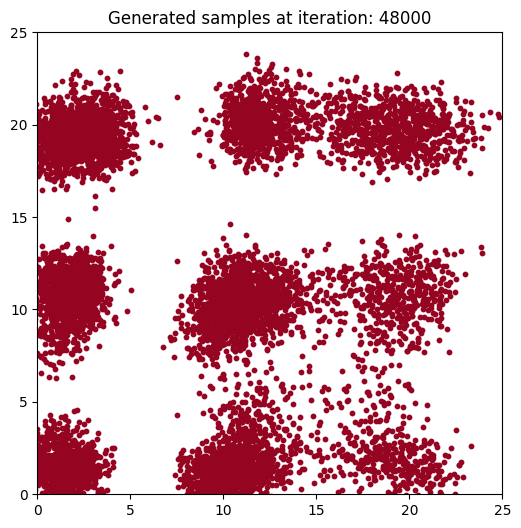

Iteration [48499/50000]	Loss 0.7644 (0.8189)

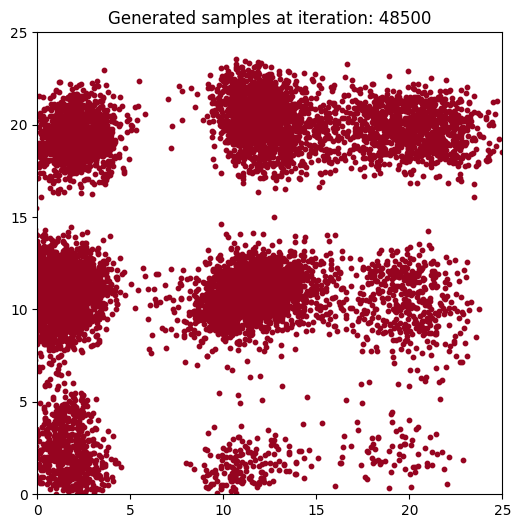

Iteration [48999/50000]	Loss 0.6785 (0.8187)

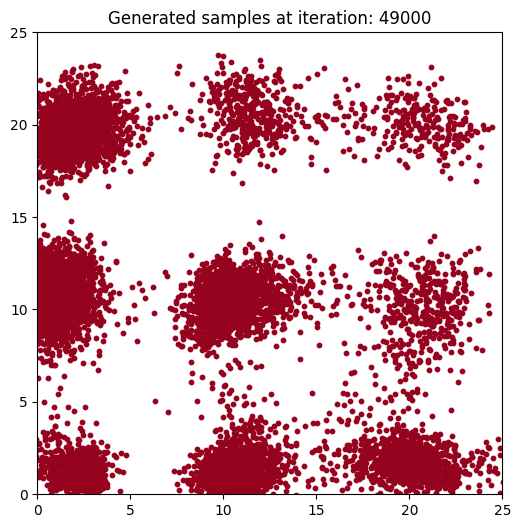

Iteration [49499/50000]	Loss 0.8613 (0.8185)

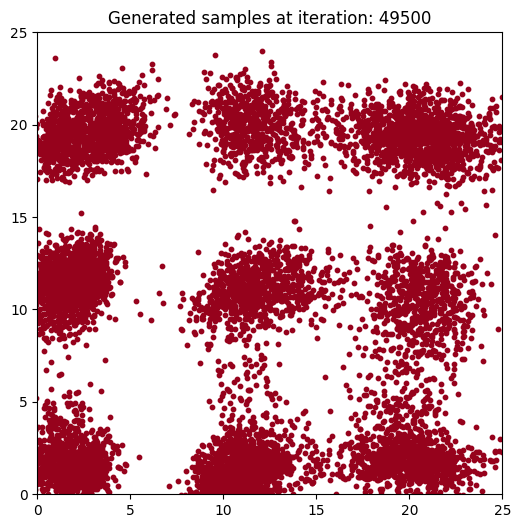

Iteration [49999/50000]	Loss 0.7051 (0.8184)

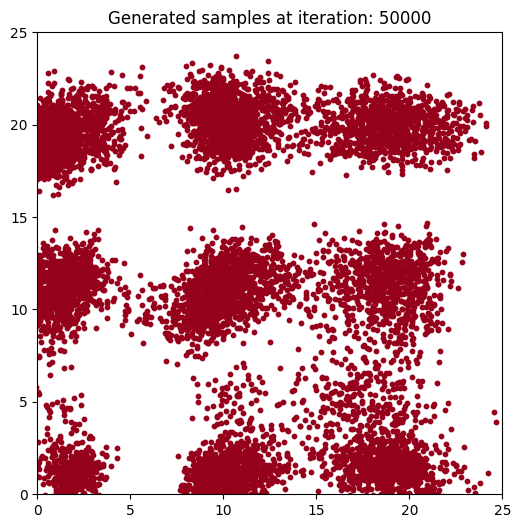

In [135]:
flag = 0
current_iteration = 0

color1 = "#8A5AC2"
color2 = "#960019"
color = get_color_gradient(color1, color2, int(total_iteration/display_iteration) + 2)

while current_iteration != total_iteration:
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = next(dataiterator)
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        fig = plt.figure(figsize=(6, 6))
        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.scatter(sample[:,0].detach().cpu().numpy(), sample[:,1].detach().cpu().numpy(), s=10, c=color[int(current_iteration/display_iteration)])
        plt.title("Generated samples at iteration: " + str(current_iteration))
        plt.show()
        #display.display(plt.gcf())
        #time.sleep(1)
        #time.sleep(4)
        #plt.cla() 